# Demonstrating alignment transforms between Connectors, including dihedral angle setting

## Define example molecules

[19:03:32] UFFTYPER: Unrecognized atom type: *_ (8)
[19:03:32] UFFTYPER: Unrecognized atom type: *_ (11)
[19:03:32] UFFTYPER: Unrecognized atom type: *_ (0)


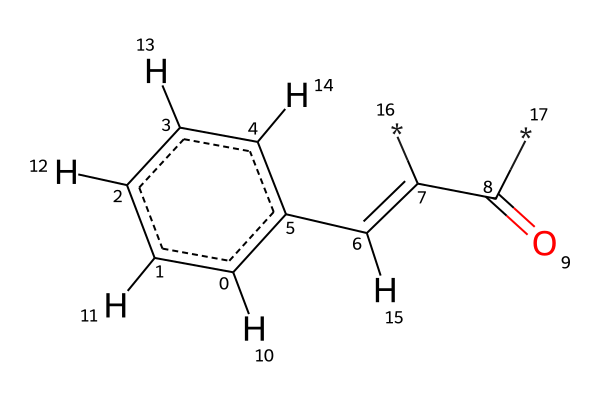

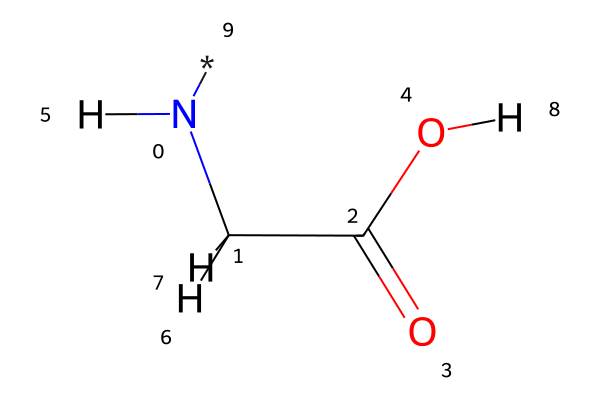

In [1]:
from mupt.interfaces.rdkit import primitive_to_rdkit
from mupt.interfaces.smiles import primitive_from_smiles


prim1 = primitive_from_smiles('c1ccccc1C=C(-[1*])C(=O)[2*]', label='cinnamic acid', embed_positions=True, ensure_explicit_Hs=True)
mol1 = primitive_to_rdkit(prim1)

prim2 = primitive_from_smiles('[3*][NH]CC(=O)O', label='glycine', embed_positions=True, ensure_explicit_Hs=True)
mol2 = primitive_to_rdkit(prim2)
for mol in (mol1, mol2):
    underscored_name : str = mol.GetProp('_Name').replace(' ', '_')
    # used to distinguish identities of distinct molecules in combined mol for selection in molecule viewers
    for atom in mol.GetAtoms():
        atom.SetProp('molFileAlias', f'{underscored_name}_A{atom.GetIdx()}')
    display(mol)

In [2]:
conn1 = list(prim1.connectors.values())[1]
conn2 = list(prim2.connectors.values())[0]

dihedral_angle : float = 0.0 # = np.pi/3
conn2_trans = conn2.antialigned_rigidly_to(conn1, dihedral_angle_rad=dihedral_angle, match_bond_length=False)
conn2_trans_matched = conn2.antialigned_rigidly_to(conn1, dihedral_angle_rad=dihedral_angle, match_bond_length=True)

print(conn1)
print(conn2)
print('==')
print(conn2_trans)
print(conn2_trans_matched)

Connector(anchor=AttachmentPoint(attachables={9, 'C'}, attachment=9, position=array([3.55857221, 0.01756199, 0.23620956])), linker=AttachmentPoint(attachables={11, '*'}, attachment=11, position=array([4.0856035 , 1.04864906, 0.58946288])), bondtype=rdkit.Chem.rdchem.BondType.SINGLE, bond_length=np.float64(1.2106570175629805), label='Conn', dihedral_plane_set=True)
Connector(anchor=AttachmentPoint(attachables={1, 'N'}, attachment=1, position=array([-1.08564555,  0.85572505,  0.14789901])), linker=AttachmentPoint(attachables={0, '*'}, attachment=0, position=array([-0.83401483,  1.33803132, -0.31641688])), bondtype=rdkit.Chem.rdchem.BondType.SINGLE, bond_length=np.float64(0.7152108703830924), label='Conn', dihedral_plane_set=True)
==
Connector(anchor=AttachmentPoint(attachables={1, 'N'}, attachment=1, position=array([4.0856035 , 1.04864906, 0.58946288])), linker=AttachmentPoint(attachables={0, '*'}, attachment=0, position=array([3.77425313, 0.4395214 , 0.38077403])), bondtype=rdkit.Chem.r

## Alignment mechanism 1: Rigid alignment
In which the first Connector remains fixed, while the second is rigidly moved to have its attachment points antialigned with the first

In [3]:
import numpy as np
from scipy.spatial.transform import Slerp, Rotation, RigidTransform

from rdkit.Chem import Conformer
from rdkit.Chem.rdMolTransforms import TransformConformer


n_steps_rotate : int = 50
n_steps_translate : int = 50
n_steps_dihedral : int = 100

# calculate and apply transform
## extract initial positions and match bond length before transforming
mol2_conf_idx : int = 0
init_conf : Conformer = mol2.GetConformer(mol2_conf_idx)
init_positions : np.ndarray = init_conf.GetPositions()

conn2.set_bond_length(conn1.bond_length) 
alignment = conn2.rigid_antialignment_to(conn1, tare_dihedrals=True)
translation, rotation = alignment.translation, alignment.rotation

## interpolate first rotation and then translation fo alignment
rotate_domain = np.linspace(0.0, 1.0, num=n_steps_rotate)
translate_domain = np.linspace(0.0, 1.0, num=n_steps_translate)

slerp = Slerp([0.0, 1.0], Rotation.concatenate([Rotation.identity(), rotation]))
turns : list[RigidTransform] = [
    RigidTransform.from_rotation(partial_rot)
       for partial_rot in slerp(rotate_domain)
]
shifts : list[RigidTransform] = [
    RigidTransform.from_components(
        translation=partial_translation,
        rotation=rotation
    )
        for partial_translation in np.outer(translate_domain, translation)
]

In [4]:
from pathlib import Path
from rdkit.Chem import SDWriter, CombineMols

alignment_dir = Path('alignments')
alignment_dir.mkdir(exist_ok=True)

# write series of intermediate transforms to SDF
rigid_align_path = alignment_dir / 'rigid_alignment.sdf'
with SDWriter(rigid_align_path) as writer:
    ## interpolate initial transform to dihedral of 0 radians
    for partial_alignment in RigidTransform.concatenate([*turns, *shifts]):
        # conn2.rigidly_transform(transformation=partial_alignment)
        mol2.GetConformer(mol2_conf_idx).SetPositions( # TODO: replace with primitive.rigidly_transform() calls
            partial_alignment.apply(init_positions)
        )
        writer.write(CombineMols(mol1, mol2), confId=0)
    conn2.antialign_rigidly_to(conn1, match_bond_length=True, tare_dihedrals=True)

    ## sweep through a full turn of dihedral angles
    for angle_rad in np.linspace(0, 2*np.pi, num=n_steps_dihedral):
        dihedral_alignment = conn2.dihedral_assignment_transform(conn1, dihedral_angle_rad=angle_rad)
        conn2.rigidly_transform(transformation=dihedral_alignment)
        TransformConformer(mol2.GetConformer(mol2_conf_idx), dihedral_alignment.as_matrix())

        writer.write(CombineMols(mol1, mol2), confId=0)
    mol2.GetConformer(mol2_conf_idx).SetPositions(init_positions) # restore initial positions after interpolating
    
print(f'Connectors ended aligned: {conn1.are_antialigned(conn2)}')

Connectors ended aligned: True


## Alignment mechanism 2: Ballistic alignment
In which the anchor sites of both Connectors remain fixed, and linker linkers are "aimed" atom the others' anchor site

### TODO